## Imports

In [1]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

## Original SimpleNet class

In [2]:
class SimpleNet(mneflow.models.LFCNN):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

    def plot_patterns(
        self, sensor_layout=None, sorting='l2', percentile=90,
        scale=False, class_names=None, info=None
    ):
        order, ts = self._sorting(sorting)
        self.uorder = order.ravel()
        l_u = len(self.uorder)
        if info:
            info.__setstate__(dict(_unlocked=True))
            info['sfreq'] = 1.
            self.fake_evoked = evoked.EvokedArray(self.patterns, info, tmin=0)
            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        elif sensor_layout:
            lo = channels.read_layout(sensor_layout)
            info = create_info(lo.names, 1., sensor_layout.split('-')[-1])
            orig_xy = np.mean(lo.pos[:, :2], 0)
            for i, ch in enumerate(lo.names):
                if info['chs'][i]['ch_name'] == ch:
                    info['chs'][i]['loc'][:2] = (lo.pos[i, :2] - orig_xy)/3.
                    #info['chs'][i]['loc'][4:] = 0
                else:
                    print("Channel name mismatch. info: {} vs lo: {}".format(
                        info['chs'][i]['ch_name'], ch))

            self.fake_evoked = evoked.EvokedArray(self.patterns, info)

            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        else:
            raise ValueError("Specify sensor layout")


        if np.any(self.uorder):
            nfilt = max(self.out_dim, 8)
            nrows = max(1, l_u//nfilt)
            ncols = min(nfilt, l_u)
            f, ax = plt.subplots(nrows, ncols, sharey=True)
            plt.tight_layout()
            f.set_size_inches([16, 3])
            ax = np.atleast_2d(ax)

            for ii in range(nrows):
                fake_times = np.arange(ii * ncols,  (ii + 1) * ncols, 1.)
                vmax = np.percentile(self.fake_evoked.data[:, :l_u], 95)
                self.fake_evoked.plot_topomap(
                    times=fake_times,
                    axes=ax[ii],
                    colorbar=False,
                    vmax=vmax,
                    scalings=1,
                    time_format="Branch #%g",
                    title='Patterns ('+str(sorting)+')',
                    outlines='head',
                )

    def branchwise_loss(self, X, y):
        model_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            model_weights = model_weights_original.copy()
            spatial_weights = model_weights[0].copy()
            spatial_biases = model_weights[1].copy()
            temporal_biases = model_weights[3].copy()
            env_biases = model_weights[5].copy()
            spatial_weights[:, i] = 0
            spatial_biases[i] = 0
            temporal_biases[i] = 0
            env_biases[i] = 0
            model_weights[0] = spatial_weights
            model_weights[1] = spatial_biases
            model_weights[3] = temporal_biases
            model_weights[5] = env_biases
            self.km.set_weights(model_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(model_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(10, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


## SimpleNet with weighted compression of envelopes

In [101]:
class SimpleNetA(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = tf.math.abs(self.envconv(self.tconv_out))
        # self.envconv_out = self.tconv_out
        # print(self.envconv_out.shape)
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        # self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]
        self.pool_list = [
            tf.keras.layers.Dense(
                pooled_dim,
                use_bias=False,
                # kernel_regularizer='l1',
                activation='sigmoid'
            )
            for _ in range(self.specs['n_latent'])
        ]
        # self.pool = DepthwiseSelectTimepointsLayer(10)
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling(self.envconv_out[:, :, :, i]))

        self.pooled = tf.stack(pooled, -1)
        # self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    # def plot_temporal
    def branchwise_loss(self, X, y):
        model_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            model_weights = model_weights_original.copy()
            spatial_weights = model_weights[0].copy()
            spatial_biases = model_weights[1].copy()
            temporal_biases = model_weights[3].copy()
            spatial_weights[:, i] = 0
            spatial_biases[i] = 0
            temporal_biases[i] = 0
            model_weights[0] = spatial_weights
            model_weights[1] = spatial_biases
            model_weights[3] = temporal_biases
            self.km.set_weights(model_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(model_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def tempwise_loss(self, X, y):
        model_weights_original = self.km.get_weights().copy()
        temp_sel_weights = model_weights_original[6:-2]
        base_loss, _ = self.km.evaluate(X, y, verbose=0)
        window_size = 5
        componentslosses = list()
        for i_latent, tem_sel_w in enumerate(temp_sel_weights):
            print(f'Processing branch {i_latent}...', end='')
            timelosses = list()
            for i_timepoint in range(0, len(tem_sel_w), window_size):
                tem_sel_w_copy = tem_sel_w.copy()
                tem_sel_w_copy[i_timepoint:i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint), :] = -1000
                temp_sel_weights_copy = temp_sel_weights.copy()
                temp_sel_weights_copy[i_latent] = tem_sel_w_copy
                model_weights = model_weights_original.copy()
                model_weights[6:-2] = temp_sel_weights_copy
                self.km.set_weights(model_weights)
                loss = self.km.evaluate(X, y, verbose=0)[0]
                timelosses += [loss for _ in range(min(window_size, len(tem_sel_w) - i_timepoint))]
            componentslosses.append(timelosses)
            print(f'\tDONE, {len(timelosses)}')
        self.km.set_weights(model_weights_original)
        self.temp_relevance_loss = - np.array(componentslosses) + base_loss

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)
        self.tempwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.tconv(self.dmx(X)).numpy()

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)
        temp_course = self.temp_relevance_loss[sorting[branch_num]]
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            sp.stats.zscore(temp_course)
        )
        temp_weight = self.pool_list[branch_num].weights[0].numpy()
        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        # temp_weight_convolved = np.convolve(np.abs(temp_weight).max(1), kernel, mode='same')
        temp_weight_convolved = np.convolve(temp_weight.mean(1), kernel, mode='same')
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            np.concatenate([
                [np.nan for _ in range(kernel_size//2)],
                sp.stats.zscore(temp_weight_convolved[kernel_size//2:-kernel_size//2]) - 5,
                [np.nan for _ in range(kernel_size//2)]
            ])
        )
        ax3.axes.yaxis.set_visible(False)
        ax3.set_ylim(-8, 3)

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(15, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


## Reading data, add noise to each epoch, visualize an epoch for one channel

In [149]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

X = epochs.get_data()
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.load_data().pick_types(meg='grad').get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)



<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [150]:
X_original = X.copy()

In [199]:
X = X_original.copy()
n_noises = 3
X_zeros = np.zeros_like(X)
for i in range(n_noises):
    start = np.random.randint(X.shape[-1])
    dist = np.random.randint(X.shape[-1] - start)
    X[:, :, start:start+dist] = 2*1e-11*np.random.random((940, 204, dist)) - 1e-11
    X_zeros[:, :, start:start+dist] += 1e-10*np.ones((940, 204, dist))

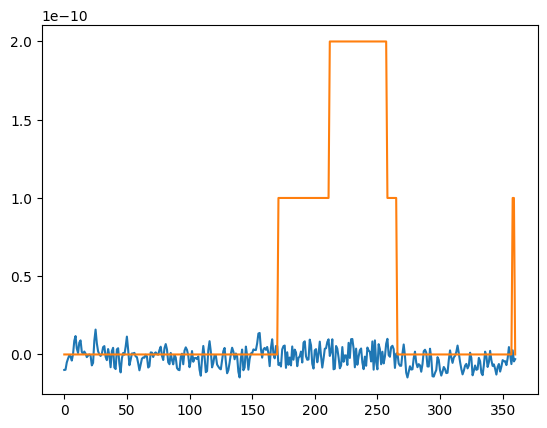

In [200]:
plt.plot(X[0, 0])
plt.plot(X_zeros[0, 0])

## Create dataset

In [201]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 30),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (940, 204, 361) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 30.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 331, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 331, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Specify parameters for SimpleNet

In [202]:
lf_params = dict(
    n_latent=16, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

## Run SimpleNet

In [203]:
model = SimpleNet(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 67, 16)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 5s - loss: 2.0673 - cat_ACC: 0.1644 - val_loss: 2.0660 - val_cat_ACC: 0.1418 - 5s/epoch - 52ms/step
Epoch 2/25
100/100 - 3s - loss: 1.8891 - cat_ACC: 0.2312 - val_loss: 1.7578 - val_cat_ACC: 0.2612 - 3s/epoch - 33ms/step
Epoch 3/25
100/100 - 3s - loss: 1.5115 - cat_ACC: 0.4253 - val_loss: 1.4416 - val_cat_ACC: 0.4328 - 3s/epoch - 30ms/step
Epoch 4/25
100/100 - 3s - loss: 1.1121 - cat_ACC: 0.6033 - val_loss: 1.0451 - val_cat_ACC: 0.5896 - 3s/epoch - 29ms/step
Epoch 5/25
100/100 - 3s - loss: 0.7787 - cat_ACC: 0.7290 - val_loss: 0.8494 - val_cat_ACC: 0.6791 - 3s/epoch - 31ms/step
Epoch 6/25
100/100 - 3s - loss: 0.5679 - c

## Check accuracy

In [159]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8461538553237915

## Try upgraded version

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 66, 16)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 8s - loss: 2.3362 - cat_ACC: 0.1304 - val_loss: 2.0403 - val_cat_ACC: 0.1308 - 8s/epoch - 84ms/step
Epoch 2/25
100/100 - 4s - loss: 1.8941 - cat_ACC: 0.2783 - val_loss: 1.3664 - val_cat_ACC: 0.6000 - 4s/epoch - 42ms/step
Epoch 3/25
100/100 - 4s - loss: 1.0828 - cat_ACC: 0.6236 - val_loss: 0.8182 - val_cat_ACC: 0.7615 - 4s/epoch - 42ms/step
Epoch 4/25
100/100 - 4s - loss: 0.5665 - cat_ACC: 0.8592 - val_loss: 0.6070 - val_cat_ACC: 0.8462 - 4s/epoch - 43ms/step
Epoch 5/25
100/100 - 4s - loss: 0.3041 - cat_ACC: 0.9520 - val_loss: 0.5090 - val_cat_ACC: 0.8692 - 4s/epoch - 42ms/step
Epoch 6/25
100/100 - 4s - loss: 0.1778 - c

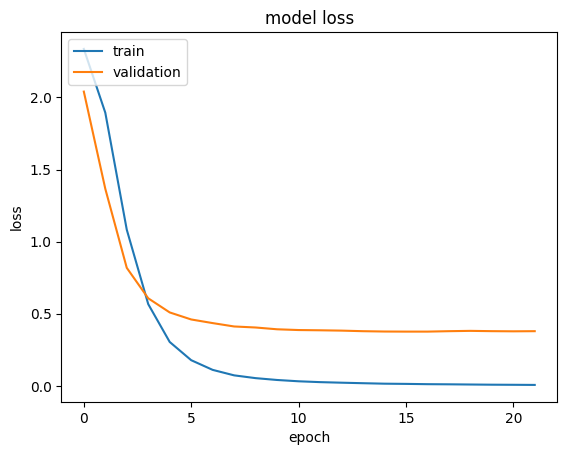

In [160]:
model = SimpleNetA(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

## Check accuracy

In [161]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8589743375778198

## Compute patterns + estimate compression weights

In [162]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)
Processing branch 0...	DONE, 331
Processing branch 1...	DONE, 331
Processing branch 2...	DONE, 331
Processing branch 3...	DONE, 331
Processing branch 4...	DONE, 331
Processing branch 5...	DONE, 331
Processing branch 6...	DONE, 331
Processing branch 7...	DONE, 331
Processing branch 8...	DONE, 331
Processing branch 9...	DONE, 331
Processing branch 10...	DONE, 331
Processing branch 11...	DONE, 331
Processing branch 12...	DONE, 331
Processing branch 13...	DONE, 331
Processing branch 14...	DONE, 331
Processing branch 15...	DONE, 331


In [163]:
w = model.pool_list[1].weights[0].numpy()

## Visualize compression weights for a branch. Its shape: n_times x n_downsampled_times

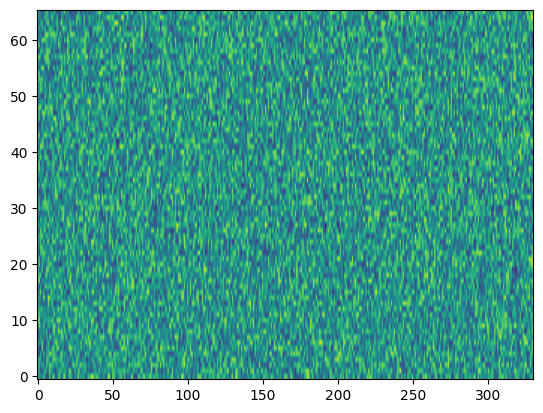

In [164]:
plt.imshow(w.T, aspect = "auto", origin = "lower")

## Plot loss-based estimate of each timepoint

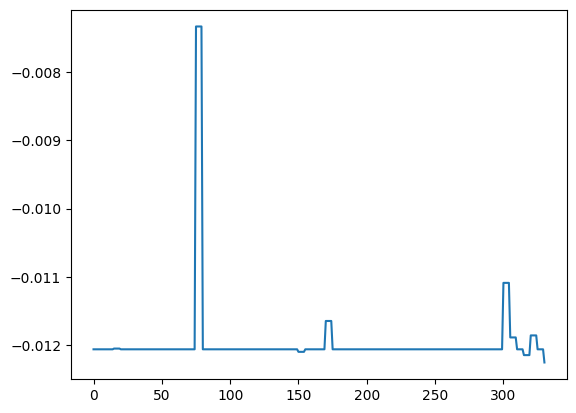

In [165]:
plt.plot(model.temp_relevance_loss[0])

## Compare with a signal from one of channels

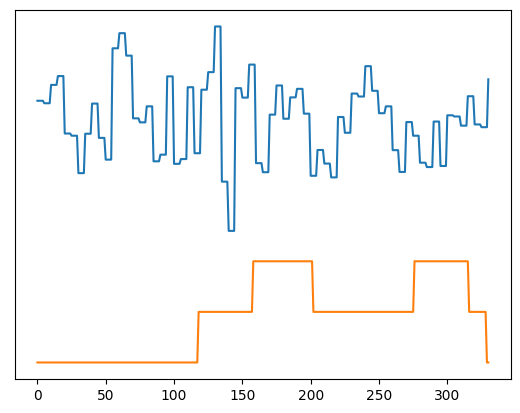

In [172]:
import scipy as sp

plt.plot(sp.stats.zscore(model.temp_relevance_loss[5]))
plt.plot(sp.stats.zscore(X_zeros[0, 0, 30:])-5)
plt.gca().axes.yaxis.set_visible(False)

In [173]:
sorting = np.argsort(model.branch_relevance_loss)[::-1]
# time_courses_filtered = np.squeeze(model.lat_tcs_filt.reshape(
#         [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
#     ))
time_courses_filtered = model.lat_tcs_filt
time_courses_env = np.zeros_like(time_courses_filtered)
kern = np.squeeze(model.envconv.filters.numpy()).T
for i_comp in range(kern.shape[0]):
    for i_ch in range(time_courses_filtered.shape[0]):
        # conv = np.convolve(time_courses_filtered[i_ch, :], kern[i_comp, :], mode="same")
        conv = np.abs(np.convolve(time_courses_filtered[i_ch, :], kern[i_comp, :], mode="same"))
        time_courses_env[i_ch, :] = conv

i = 4

time_courses_env = np.squeeze(time_courses_env.reshape(
        [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
    ))
time_courses_filtered = np.squeeze(time_courses_filtered.reshape(
        [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
    ))
time_courses_env = np.expand_dims(np.transpose(time_courses_env, (1, 2, 0)), (1, -2))

selected_time_course = np.array(time_courses_env)[:, :, :, :, sorting][:, :, :, :, i]
selected_time_course_plot = np.squeeze(selected_time_course)
selected_w =  model.pool_list[sorting[i]].weights[0].numpy()
selected_temp_relevance_loss = model.temp_relevance_loss[sorting[i]]

In [174]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

In [191]:
selected_time_course_plot.mean(0).shape

(331,)

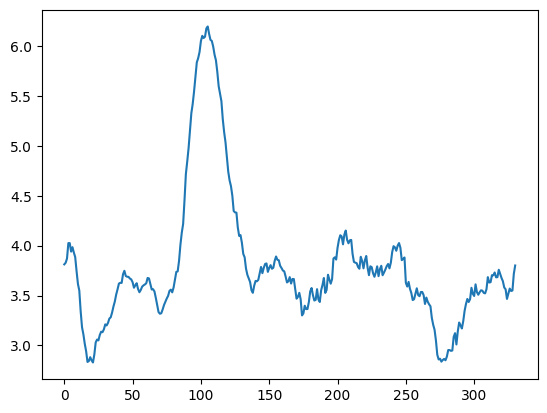

In [194]:
plt.plot(selected_time_course_plot.mean(0))

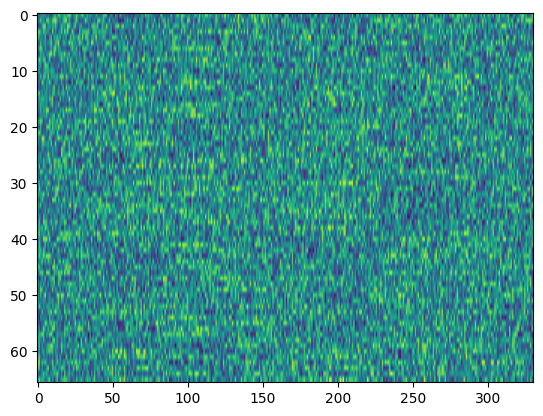

In [175]:
plt.imshow(sigmoid(selected_w).T, aspect = "auto")

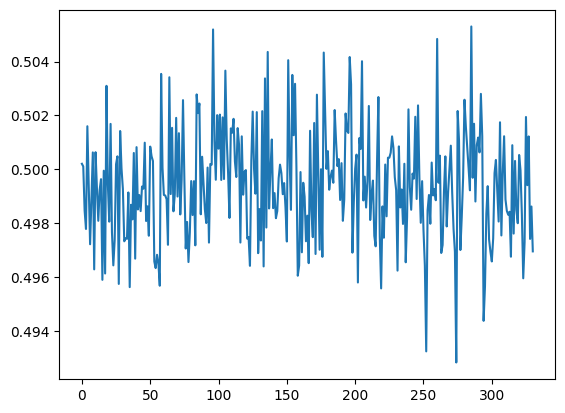

In [176]:
plt.plot(sigmoid(selected_w).mean(1))

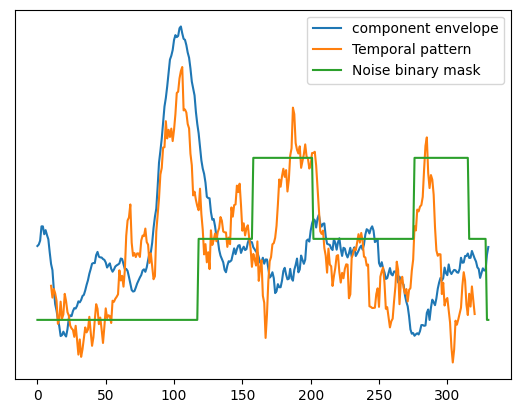

In [182]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(sigmoid(selected_w).mean(1), kernel, mode='same')
# plt.plot(
#     np.concatenate([
#         [np.nan for i in range(10)],
#         sp.stats.zscore(data_convolved[10:-10])+5,
#         [np.nan for i in range(10)],
#     ])
# )
data_convolved = np.convolve(selected_w.mean(1), kernel, mode='same')
plt.plot(sp.stats.zscore(selected_time_course_plot.mean(0))-0)
plt.plot(
    np.concatenate([
        [np.nan for i in range(10)],
        sp.stats.zscore(data_convolved[10:-10]),
        [np.nan for i in range(10)],
    ])
)
plt.plot(sp.stats.zscore(X_zeros[0, 0, 30:]))
plt.legend(['component envelope', 'Temporal pattern', 'Noise binary mask'])
plt.gca().axes.yaxis.set_visible(False)

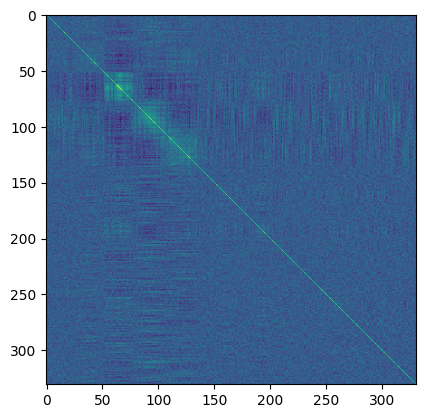

In [99]:
plt.imshow(np.cov(selected_w))

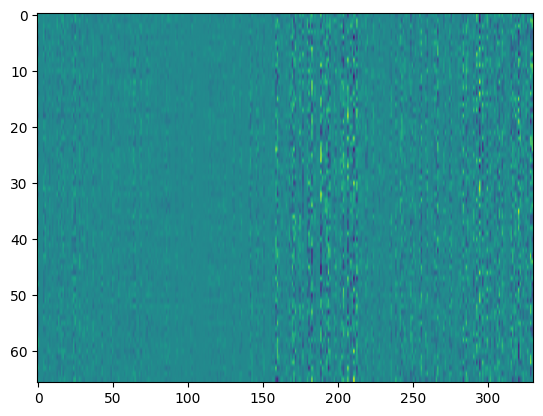

In [69]:
plt.imshow(sigmoid(selected_w_weighted), aspect = "auto")

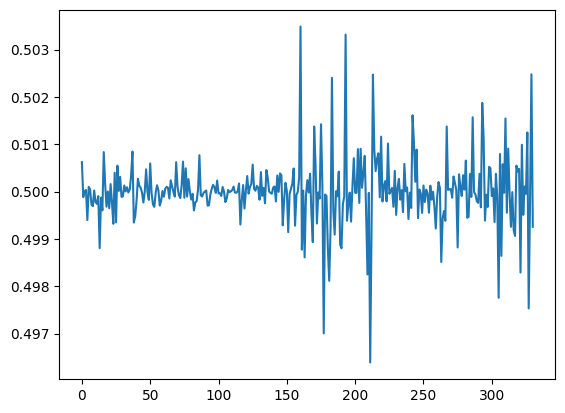

In [67]:
plt.plot(sigmoid(selected_w_weighted).mean(0))

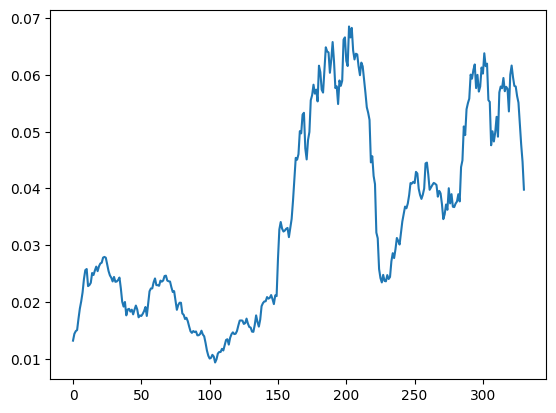

In [44]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(selected_w_weighted.max(0), kernel, mode='same')
plt.plot(data_convolved)

In [36]:
# plt.plot(selected_temp_relevance_loss)
plt.plot(selected_time_course_plot.mean(0)@selected_w)

SyntaxError: invalid syntax (2186153508.py, line 2)

## Absolute walues of weights

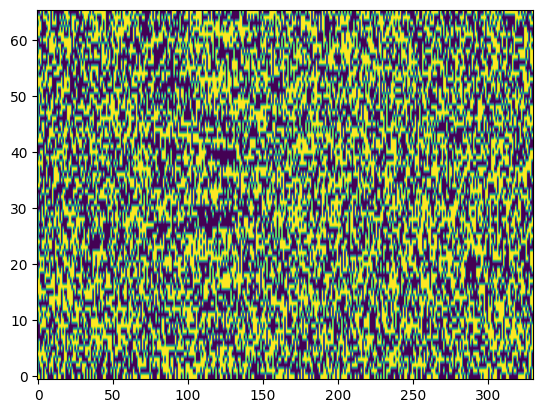

In [105]:
plt.imshow(np.heaviside(w, .5).T, aspect='auto', origin='lower')

## Moving average of mean values - another way to estimate timepoints

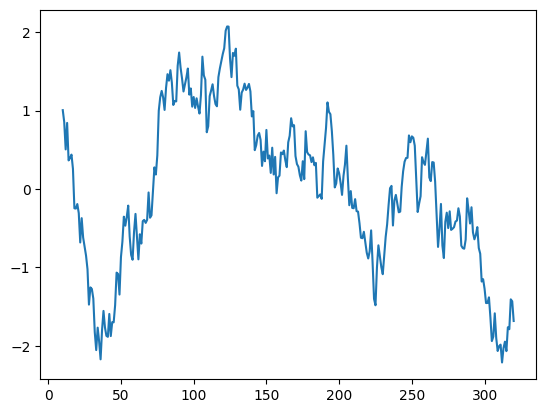

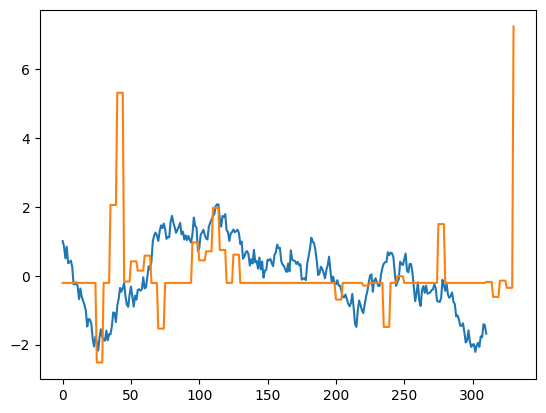

In [134]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(w.mean(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(w.mean(1)))
plt.plot(
    np.append(
        [np.nan for _ in range(kernel_size//2)],
        sp.stats.zscore(data_convolved[kernel_size//2:-kernel_size//2])
    )
)
plt.show()
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(w.mean(1), kernel, mode='same')
plt.plot(sp.stats.zscore(data_convolved[10:-10]))
plt.plot(sp.stats.zscore(model.temp_relevance_loss[1]))
plt.show()

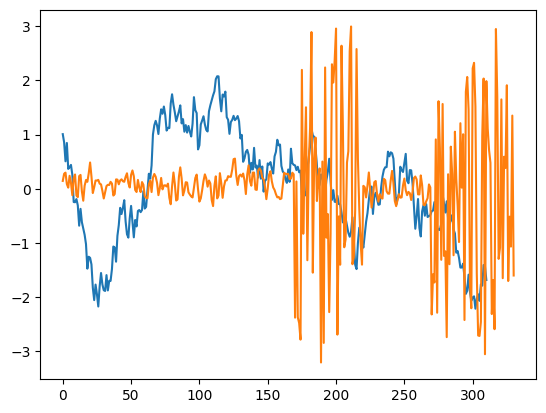

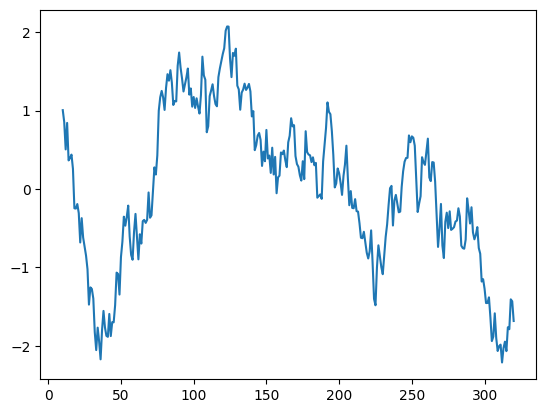

In [135]:
kernel_size = 20
w = model.pool_list[1].weights[0].numpy()
kernel = np.ones(kernel_size) / kernel_size
# data_convolved = np.convolve(np.abs(w).max(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(data_convolved[10:-10]))
# data_convolved = np.convolve(np.abs(w).sum(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(data_convolved[10:-10]))
# data_convolved = np.convolve(np.abs(w).mean(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(data_convolved[10:-10]))
# data_convolved = np.convolve(w.sum(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(data_convolved[10:-10]))
data_convolved = np.convolve(w.mean(1), kernel, mode='same')
plt.plot(sp.stats.zscore(data_convolved[10:-10]))
# data_convolved = np.convolve(np.heaviside(w, 0.5).sum(1), kernel, mode='same')
# plt.plot(sp.stats.zscore(data_convolved[10:-10]))
plt.plot(sp.stats.zscore(X[0, 0, 30:]))
# plt.legend(['abs.max', 'abs.sum', 'abs.mean', 'sum', 'mean', 'hw', 'sig'])
plt.show()
plt.plot(
    np.append(
        [np.nan for _ in range(kernel_size//2)],
        sp.stats.zscore(data_convolved[kernel_size//2:-kernel_size//2])
    )
)
plt.plot(sp.stats.zscore(model.temp_relevance_loss[0]))
plt.show()

## Compare with a signal from one of channels

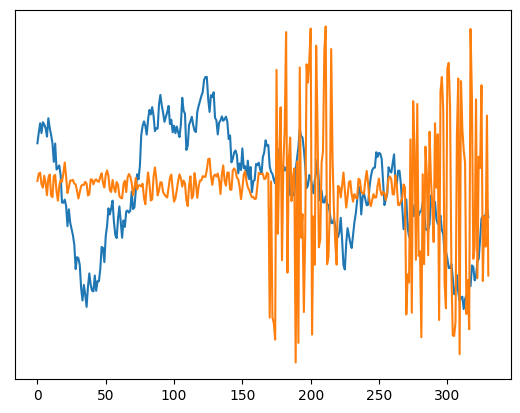

In [136]:
plt.plot(sp.stats.zscore(data_convolved))
plt.plot(sp.stats.zscore(X[0, 0, 30:]))
plt.gca().axes.yaxis.set_visible(False)

## Visualize 1st branch (branch importance estimated according to its loss)

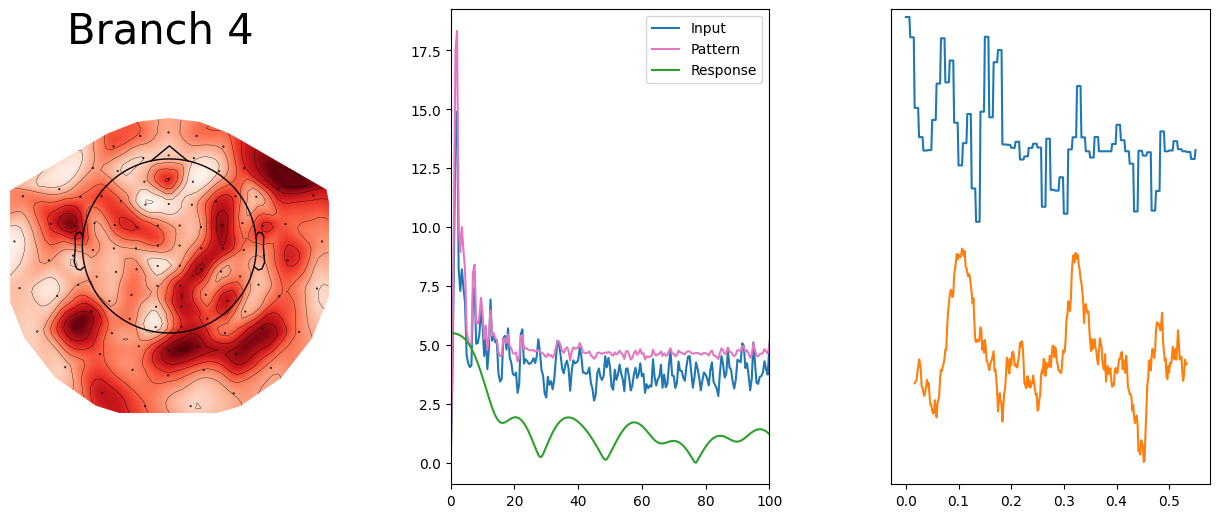

In [100]:
fig = model.plot_branch(4, epochs.info, params=['input', 'pattern', 'response'])